In [ ]:
import os
import zipfile
import pandas as pd
from google.colab import files

In [ ]:
#Upload dataset zip
print("/content/Alzheimer_s_dataset.csv")
uploaded = files.upload()

/content/Alzheimer_s_dataset.csv


Saving Alzheimer_s Dataset.zip to Alzheimer_s Dataset.zip


In [ ]:
#Extract uploaded zip
for fname in uploaded.keys():
    print(f"Extracting {fname} ...")
    with zipfile.ZipFile(fname, 'r') as zip_ref:
        # Extract ZIP into a folder (no .zip in folder name)
        zip_ref.extractall("/content/dataset")

# Path to the extracted dataset folder
dataset_path = "/content/dataset"

Extracting Alzheimer_s Dataset.zip ...


In [ ]:
#List the main folders
print("\nContents of dataset folder:")
print(os.listdir(dataset_path))


Contents of dataset folder:
['Alzheimer_s Dataset', '__MACOSX']


In [ ]:
#Convert images to CSV (image path + label)
data = []
for root, dirs, files_in_dir in os.walk(dataset_path):
    for file in files_in_dir:
        if file.endswith((".jpg", ".jpeg", ".png")):  # only images
            file_path = os.path.join(root, file)
            label = os.path.basename(root)  # folder name as label
            data.append([file_path, label])

In [ ]:
#Create DataFrame and save as CSV
df = pd.DataFrame(data, columns=["image_path", "label"])
csv_path = "/content/Alzheimer_s_dataset.csv"
df.to_csv(csv_path, index=False)
print(f"\nCSV file saved at: {csv_path}")



CSV file saved at: /content/Alzheimer_s_dataset.csv


In [ ]:
#Download CSV to your computer
files.download(csv_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install tensorflow scikit-learn xgboost matplotlib pillow

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
#Load CSV
csv_path = "/content/Alzheimer_s_dataset.csv"  # path to your CSV
df = pd.read_csv(csv_path)
print(df.head())

                                          image_path             label
0  /content/dataset/Alzheimer_s Dataset/test/Very...  VeryMildDemented
1  /content/dataset/Alzheimer_s Dataset/test/Very...  VeryMildDemented
2  /content/dataset/Alzheimer_s Dataset/test/Very...  VeryMildDemented
3  /content/dataset/Alzheimer_s Dataset/test/Very...  VeryMildDemented
4  /content/dataset/Alzheimer_s Dataset/test/Very...  VeryMildDemented


In [ ]:
#Load images and preprocess
IMAGE_SIZE = (64, 64)  # resize for faster training
images = []
labels = []

for idx, row in df.iterrows():
    img_path = row['image_path'].replace('/content/Alzheimer_s Dataset/', '/content/dataset/')
    label = row['label']
    # Skip files in __MACOSX folder
    if '__MACOSX' in img_path:
        continue
    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize(IMAGE_SIZE)
        img = np.array(img) / 255.0  # normalize to 0-1
        images.append(img)
        labels.append(label)
    except:
        continue

X = np.array(images)
y = np.array(labels)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# For CNN we need one-hot labels
y_cnn = to_categorical(y_encoded)

In [ ]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X, y_cnn, test_size=0.2, random_state=42)

# Flatten images for tree-based models
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


In [ ]:
#Model 1 - Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_flat, y_train)
y_pred_rf = rf.predict(X_test_flat)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("\nRandom Forest Accuracy:", acc_rf)

#Model 2 - XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_flat, y_train)
y_pred_xgb = xgb_model.predict(X_test_flat)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("\nXGBoost Accuracy:", acc_xgb)

#Model 3 - Simple CNN
cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
     MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = cnn.fit(X_train_cnn, y_train_cnn, validation_split=0.1, epochs=10, batch_size=32, verbose=1)
cnn_acc = cnn.evaluate(X_test_cnn, y_test_cnn, verbose=0)[1]
print("\nCNN Accuracy:", cnn_acc)


Random Forest Accuracy: 0.95625


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:24:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Accuracy: 0.98515625


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.4942 - loss: 1.0508 - val_accuracy: 0.5957 - val_loss: 0.9436
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5687 - loss: 0.8982 - val_accuracy: 0.5820 - val_loss: 0.8385
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6387 - loss: 0.7940 - val_accuracy: 0.6934 - val_loss: 0.6835
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7103 - loss: 0.6500 - val_accuracy: 0.7930 - val_loss: 0.5103
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8139 - loss: 0.4589 - val_accuracy: 0.7461 - val_loss: 0.5449
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8748 - loss: 0.3245 - val_accuracy: 0.9102 - val_loss: 0.2455
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9210 - loss: 0.2257 - val_accuracy: 0.9316 - val_loss: 0.1911
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9528 - loss: 0.1382 - val_accuracy: 0

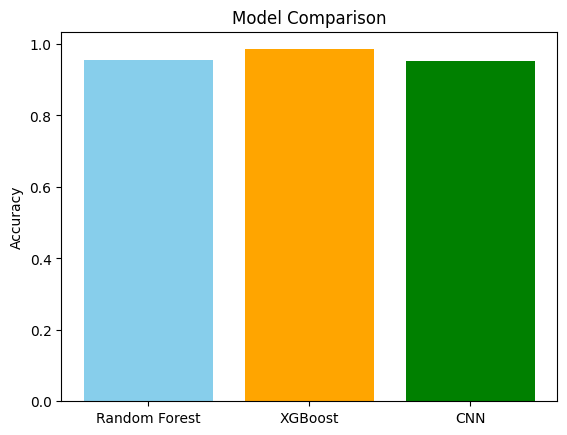

In [ ]:
#Model Comparison
model_names = ['Random Forest', 'XGBoost', 'CNN']
accuracies = [acc_rf, acc_xgb, cnn_acc]

plt.bar(model_names, accuracies, color=['skyblue','orange','green'])
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()


Enter an image index (0 to 1279) to predict, or -1 to exit: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Actual label: NonDemented
Predicted label: NonDemented


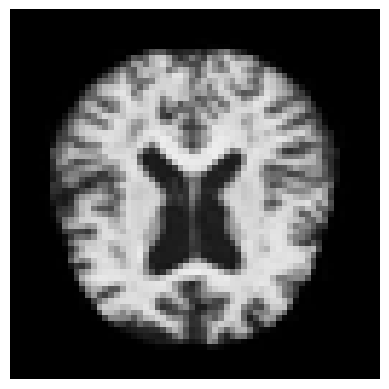

In [ ]:
# Step 10: Interactive prediction from test set
while True:
    try:
        sample_idx = int(input(f"\nEnter an image index (0 to {len(X_test)-1}) to predict, or -1 to exit: "))
        if sample_idx == -1:
            print("Exiting...")
            break
        if sample_idx < 0 or sample_idx >= len(X_test):
            print("Invalid index! Try again.")
            continue

        # Get the image
        sample_img = X_test[sample_idx].reshape(1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

        # Predict using CNN
        pred_class_cnn = le.inverse_transform([np.argmax(cnn.predict(sample_img))])[0]

        # Show actual vs predicted
        actual_label = le.inverse_transform([y_test[sample_idx]])[0]
        print(f"\nActual label: {actual_label}")
        print(f"Predicted label: {pred_class_cnn}")

        # Optional: display image
        import matplotlib.pyplot as plt
        plt.imshow(X_test[sample_idx])
        plt.axis('off')
        plt.show()

    except ValueError:
        print("Please enter a valid number.")
